<a href="https://colab.research.google.com/github/iakob12345/Wine-Project/blob/master/Wine_4_Modeling_Scaling_Factors.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1.5 Scaling factors & Significance Tests**#

---



# **The problem:**

So far, the rating of a bottle was simply a mean of all ratings associated to it. However, it didn't account for the sample size of reviewers that contributed to it. 

We believe that the truthfulness of bottle's rating is strengthened as it receives higher than average reviews compared to its category average and wekeaned if vice versa.

For example, two different wines that are sold for 10 euros each and have a rating of 4.0, will both receive a value of 40 (*(4/10) * 100*) even if the first bottle was rated by 5,000 reviewers and the second by 50.
Therefore, in this chapter, we would like to create a statistical model that rewards ratings of those wines that have high nr of reviews over low number of reviews.

In other words, the idea is to scale (**$\sigma$**) the rating_avg ($\overline{R}$) and ultimately the Value ($V$).

#**Methodology of a model**

## Sigmoid Scaling factors for avg Rating ($\overline{R}$) & Value ($V$)


To tackle this problem, we will be using a sigmoid functional form that scales the average Rating $\overline{R}$ according to the Z-score of the number of reviews per wine ($N_{r}$) compared to average review number the category that it belongs to.
<br> Z score is a measure of how many standard deviations below or above the population mean a raw score is.

Our goal is to devalue wines that have less reviews than the population mean **more than** rewarding those wines that have above average review count.

     

The sigmoid saling Factor will behave in the following manner: 

When the Z score is -2.0 ---> Value Multiplier: 0.4
When the Z score is -1.5 ---> Value Multiplier: 0.6
When the Z score is -1.0 ---> Value Multiplier: 0.7
When the Z score is -0.5 ---> Value Multiplier: 0.9
When the Z score is  0.0 ---> Value Multiplier: 1.0
When the Z score is  0.5 ---> Value Multiplier: 1.1
When the Z score is  1.0 ---> Value Multiplier: 1.1
When the Z score is  1.5 ---> Value Multiplier: 1.2




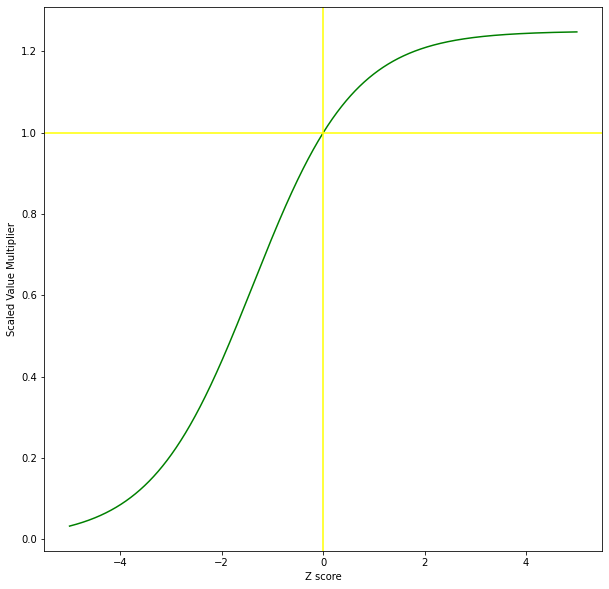

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import math
  

def scaling_factor(variable):
  scaled_factor = 5/(4 + np.exp(-variable))
  return scaled_factor

print("The sigmoid saling Factor will behave in the following manner: \n")
z_range = [x / 2.0 for x in range(-4, 4, 1)]
for step in z_range:
  value = round(scaling_factor(step),1)
  step = float(step)
  if step < 0:
    print("When the Z score is {} ---> Value Multiplier: {}".format(step,value))
  else:
    print("When the Z score is  {} ---> Value Multiplier: {}".format(step,value))

print("\n")
z_scores = np.linspace(-5, 5, 10000)
plt.figure(figsize=(10,10))
plt.plot(z_scores, scaling_factor(z_scores), color='green')
plt.xlabel("Z score")
plt.ylabel("Scaled Value Multiplier")
plt.axvline(x=0, color = 'yellow')
plt.axhline(y=1, color = 'yellow')

plt.show()

# **Data introduction**

## Libraries Imported

In [ ]:
from google.colab import drive
import pandas as pd
import numpy as np
from numpy import arange
from scipy.stats import zscore
from matplotlib import pyplot


drive.mount('/content/drive/')
path='/content/drive/My Drive/Colab Notebooks/winedata_df_after_data_wrangling.pkl'

# read cvs in Pandas
winedata_df = pd.read_pickle(path)

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
winedata_df.shape

(24300, 16)

# **Modeling**
Firstly, we will derive mean and standard deviation of review count for each category in order to come up with a Z score for each bottle. Z score is important for Scaling Factors modeling below.

In [ ]:
# Since we are introducing review counts for each category, I will call count of reviews per wine more explicitly.
# Also, we will rename value to 'value_origina' for the same reason
winedata_df.rename(columns={'total_reviews':'count_reviews_per_wine','value':'value_original'},inplace=True)

# Create Average number of reviews per category
winedata_df['avg_revs_cat'] = winedata_df.groupby('category')['count_reviews_per_wine'].transform(np.mean)

# Deriving standard deviation of each category
winedata_df['std_revs_cat'] = winedata_df.groupby('category')['count_reviews_per_wine'].transform(np.std)

# Deriving Z scores of each bottle per its category
winedata_df['Zscore_count_reviews_per_wine'] = winedata_df.apply(lambda x: (x.count_reviews_per_wine - x.avg_revs_cat)/x.std_revs_cat,axis=1)

### Filling NAN with Zeroes in Zscores (only one wine per category makes std=0, and undefines the Z-score) ###
winedata_df['Zscore_count_reviews_per_wine'] = winedata_df['Zscore_count_reviews_per_wine'].fillna(0)


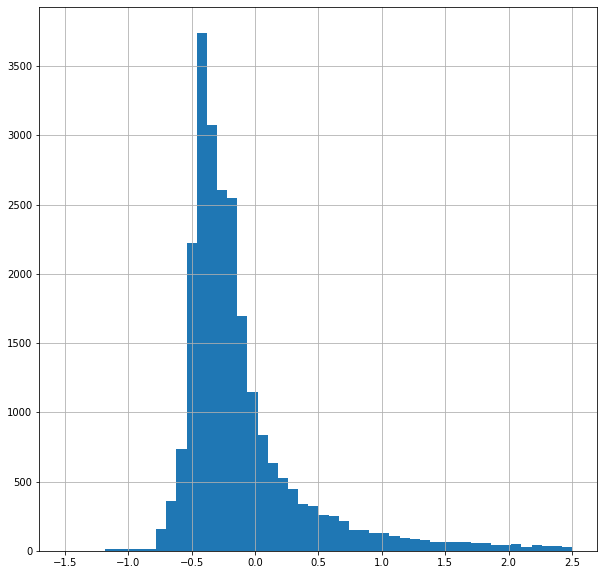

In [ ]:
#Exploring the frequency table of Z scores
winedata_df['Zscore_count_reviews_per_wine'].hist(bins=50, range=(-1.5,2.5),figsize = (10,10))


In [ ]:
def Z_scaling_factor(df):
  variable = df['Zscore_count_reviews_per_wine']
  scaled_factor = 5/(4 + np.exp(-variable))
  return scaled_factor

In [ ]:
# Calculate sigma_Z2 # value
winedata_df['Z_scaling_factor'] = winedata_df.apply(lambda row: Z_scaling_factor(row), axis=1)

# Apply Z_scaling_factor to the Average Rating 
winedata_df['R_Z_scaling_factor'] = winedata_df.apply(lambda row: row.rating_avg * row.Z_scaling_factor, axis=1)

# Calculate Value_Z2 using 'R_Z_scaling_factor' and name it value_after_Z_scaling_factor#
winedata_df['value_after_Z_scaling_factor'] = winedata_df.apply(lambda row: (row.R_Z_scaling_factor / row.price) * 100, axis=1)

# renaming for a better readability
winedata_df.rename(columns={'value_after_Z_scaling_factor':'value_scaled'},inplace=True)

# **Results**


In [ ]:
winedata_df['difference_values'] = winedata_df['value_scaled'] - winedata_df['value_original']
scaling_factor_results = winedata_df[['link','count_reviews_per_wine','avg_revs_cat','value_original','value_scaled','difference_values']]


In [ ]:
# Here we see how scaling factors behaved when particular wines were under-reviewed compared to its category

scaling_factor_results.sort_values(by='difference_values',ascending=True).head(5)

,link,count_reviews_per_wine,avg_revs_cat,value_original,value_scaled,difference_values
61,https://www.vivino.com/sohnlein-brillant-white...,25,890.947266,92.73,83.448199,-9.281801
89,https://www.vivino.com/mas-janeil-rose-gc9c1/w...,25,714.814318,85.71,76.608284,-9.101716
10,https://www.vivino.com/romer-mosel-saar-ruwer-...,164,890.947266,106.58,97.789856,-8.790144
212,https://www.vivino.com/san-marzano-i-tratturi-...,26,714.814318,80.00,71.514842,-8.485158
18,https://www.vivino.com/faber-82953-sekt-rot-mi...,46,890.947266,85.71,77.364373,-8.345627


In [ ]:
# Here we see how scaling factors behaved when particular wines were more reviewed than its category as a whole

scaling_factor_results.sort_values(by='difference_values',ascending=False).head(5)

,link,count_reviews_per_wine,avg_revs_cat,value_original,value_scaled,difference_values
42,https://www.vivino.com/riunite-lambrusco-emili...,15045,691.690859,99.48,124.318137,24.838137
43,https://www.vivino.com/gazela-vinho-verde-bran...,9354,358.161864,90.91,113.514481,22.604481
74,https://www.vivino.com/pt-borges-gatao-vinho-v...,6309,358.161864,87.50,108.636941,21.136941
213,https://www.vivino.com/vigneti-del-salento-pri...,7226,691.690859,80.00,98.993108,18.993108
120,https://www.vivino.com/lacheteau-rose-d-anjou/...,3556,714.814318,87.56,105.581865,18.021865


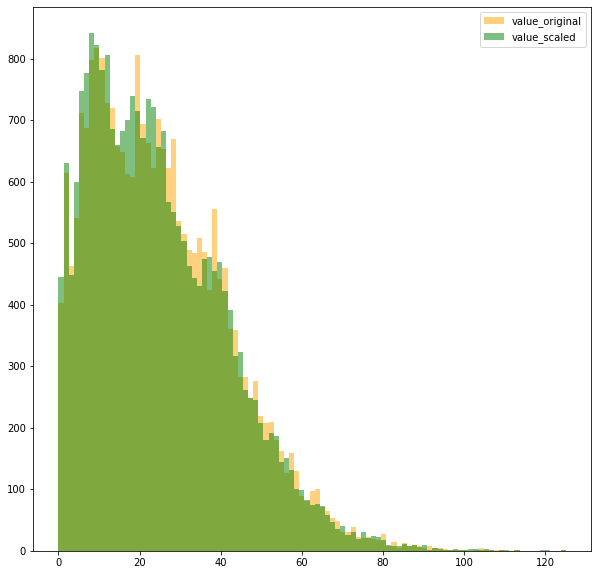

In [ ]:
x = scaling_factor_results['value_original']
y = scaling_factor_results['value_scaled']

bins = np.linspace(0, 125, 100)

pyplot.figure(figsize=(10,10))
pyplot.hist(x, bins, alpha=0.5, label='value_original',color='orange')
pyplot.hist(y, bins, alpha=0.5, label='value_scaled',color='green')
pyplot.legend(loc='upper right')
pyplot.show()

#dark green represents that values were kept the same
#yellow represents that values dropped
#light green represents that values increased

# **Inferences**
Above Frequency Table as well as granular inspection wine sample confirm what we intended to achieve - we wanted to reward highly reviewed wines and vice versa: penalise less reviewed wines, but not to the extent that overall distribution changed. Here, we see that the dataset is still right skewed and the modifications played a refinement purpose as opposed to completely altering the value proposition. 
With this in mind, in the later stages, we will be using field 'value_after_Z_scaling_factor' as the ultimate value identifier field.

# **Save Scaled Data**

In [ ]:
winedata_df.shape

(24300, 23)

In [ ]:
## Clean dataframe and make local copy ##
scaled_df = winedata_df
### clean_db saved as pickle
scaled_df.to_pickle('/content/drive/My Drive/Colab Notebooks/winedata_df_after_scaling_factor.pkl')